In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


### Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


<AxesSubplot:xlabel='login_time'>

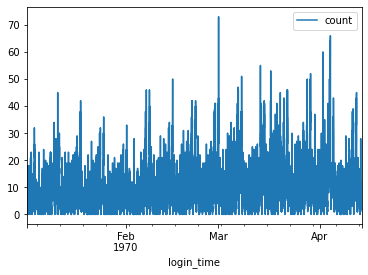

In [2]:
logins = pd.read_json('logins.json')
logins['count'] = 1
logins = logins.set_index('login_time')
logins.resample('15Min').sum().plot()

There appears to have daily monthly cycling going on for this data and a pattern where it is the highest at certain day of the month.  We will resample by day and see if we can get rid of the noise

<AxesSubplot:xlabel='login_time'>

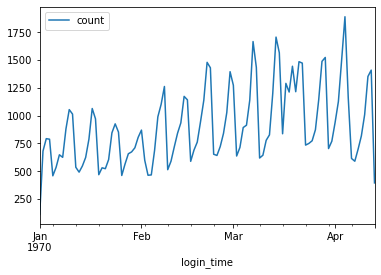

In [3]:
logins.resample('1D').sum().plot()

Ok, Yeah this is better.  You can see the oscillation going up but it is consistent between weeks, but the oscillation frequency is constant

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


### Answers, Assuming the Ultimate is Uber like Drive share service


1. I would do an A/B experiment and see whether the picking up number gets more balanced during the weekend between the two cities after all toll costs have been reimbursed.  This is the best metric because we want to see whether services have become more evenly distributed.  
2. We track the location of the pickup, at which city.  Once we have that, we can compare how the number of pickup changed between the two city before and after reimbursing is applied.  In addition, we will use Student T-Test to evaluate significant.  If the tolls works I would encourage the city operation to remove the toll to imporve service reach. 


### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).


In [4]:
ultimate =  pd.read_json('ultimate_data_challenge.json')
ultimate.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [5]:
ultimate.info()  #Since we have so many line.  We will probably just drop the NaN Column.  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [7]:
ultimate = ultimate.fillna(ultimate.mean())
ultimate.dtypes

ultimate['last_trip_date'] = ultimate['last_trip_date'].apply(lambda x : pd.to_datetime(x))
ultimate['signup_date'] = ultimate['signup_date'].apply(lambda x : pd.to_datetime(x))
ultimate['date_delta'] = ultimate['last_trip_date'] - ultimate['signup_date']
ultimate['active'] = ultimate['date_delta'] < pd.Timedelta('30 days')
ultimate  # Now we have our label we can start doing some data analysis

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,date_delta,active
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,143 days,False
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,96 days,False
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1 days,True
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,170 days,False
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,47 days,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,131 days,False
49996,Astapor,1,2014-01-24,4.601559,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,1 days,True
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,111 days,False
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,1 days,True


<AxesSubplot:ylabel='active'>

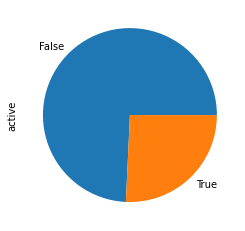

In [8]:
ultimate.active.value_counts().plot.pie() # roughly 70 percent of user are not in the system anymore

<AxesSubplot:xlabel='active', ylabel='avg_rating_by_driver'>

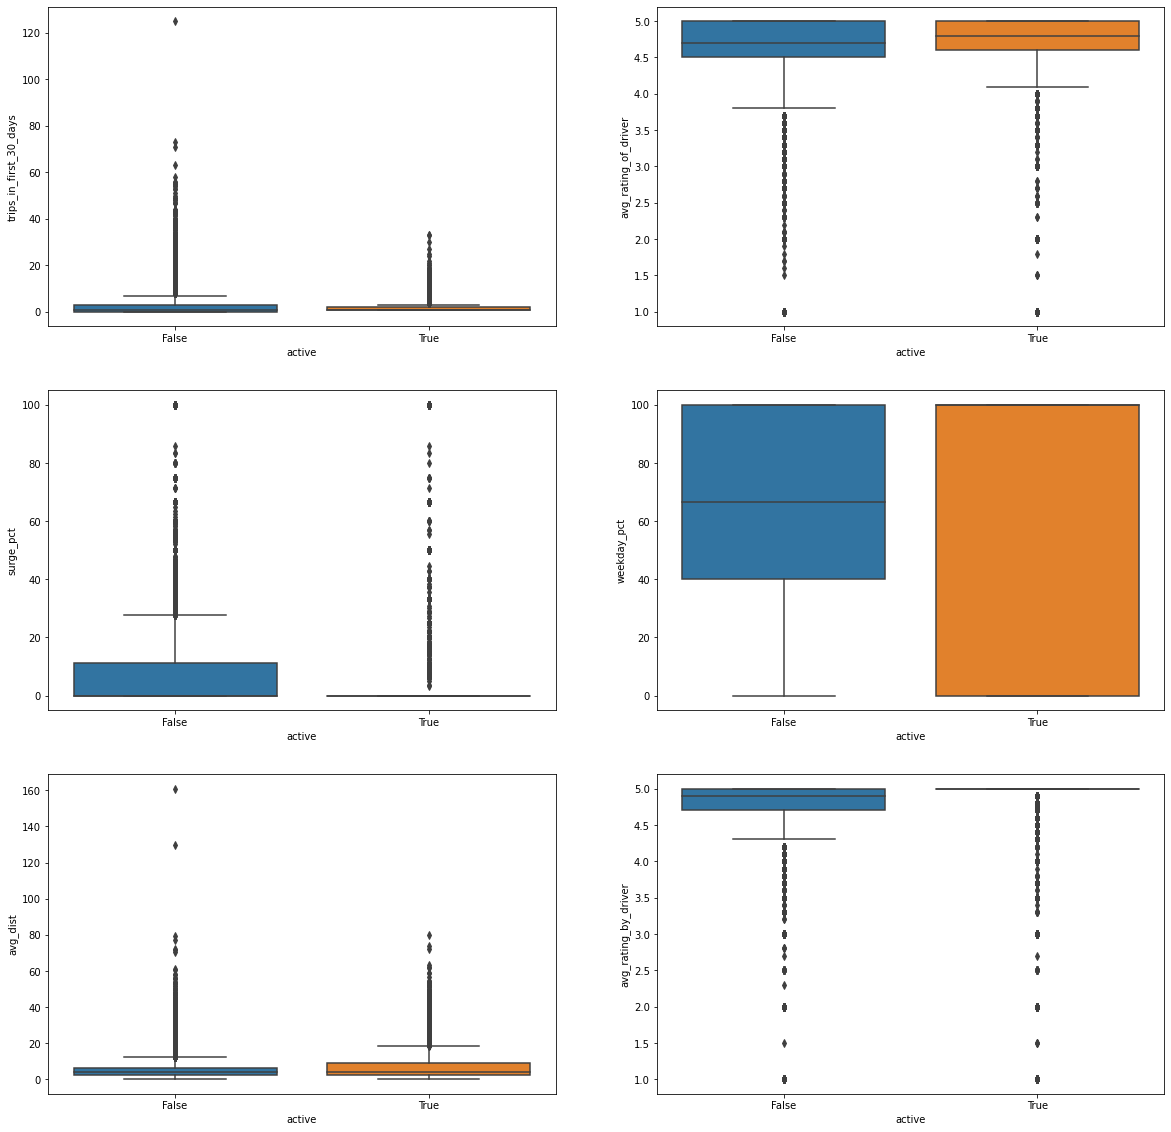

In [9]:
fig, axes = plt.subplots(3, 2 , figsize  = (20,20) )

sns.boxplot(x ='active', y = 'trips_in_first_30_days', data = ultimate , ax=axes[0,0])
sns.boxplot(x ='active', y = 'avg_rating_of_driver', data = ultimate , ax=axes[0,1])
sns.boxplot(x ='active', y = 'surge_pct', data = ultimate , ax=axes[1,0])
sns.boxplot(x ='active', y = 'weekday_pct', data = ultimate , ax=axes[1,1])
sns.boxplot(x ='active', y = 'avg_dist', data = ultimate , ax=axes[2,0])
sns.boxplot(x ='active', y = 'avg_rating_by_driver', data = ultimate , ax=axes[2,1])

Drivers rating looks like a good indicate whether if it is an active driver or not, so is surge percentage.  In addition, I am going to keep the outlier here because they are real number and doesn't look like an error.  Now, let's check if there are any colinearlity

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


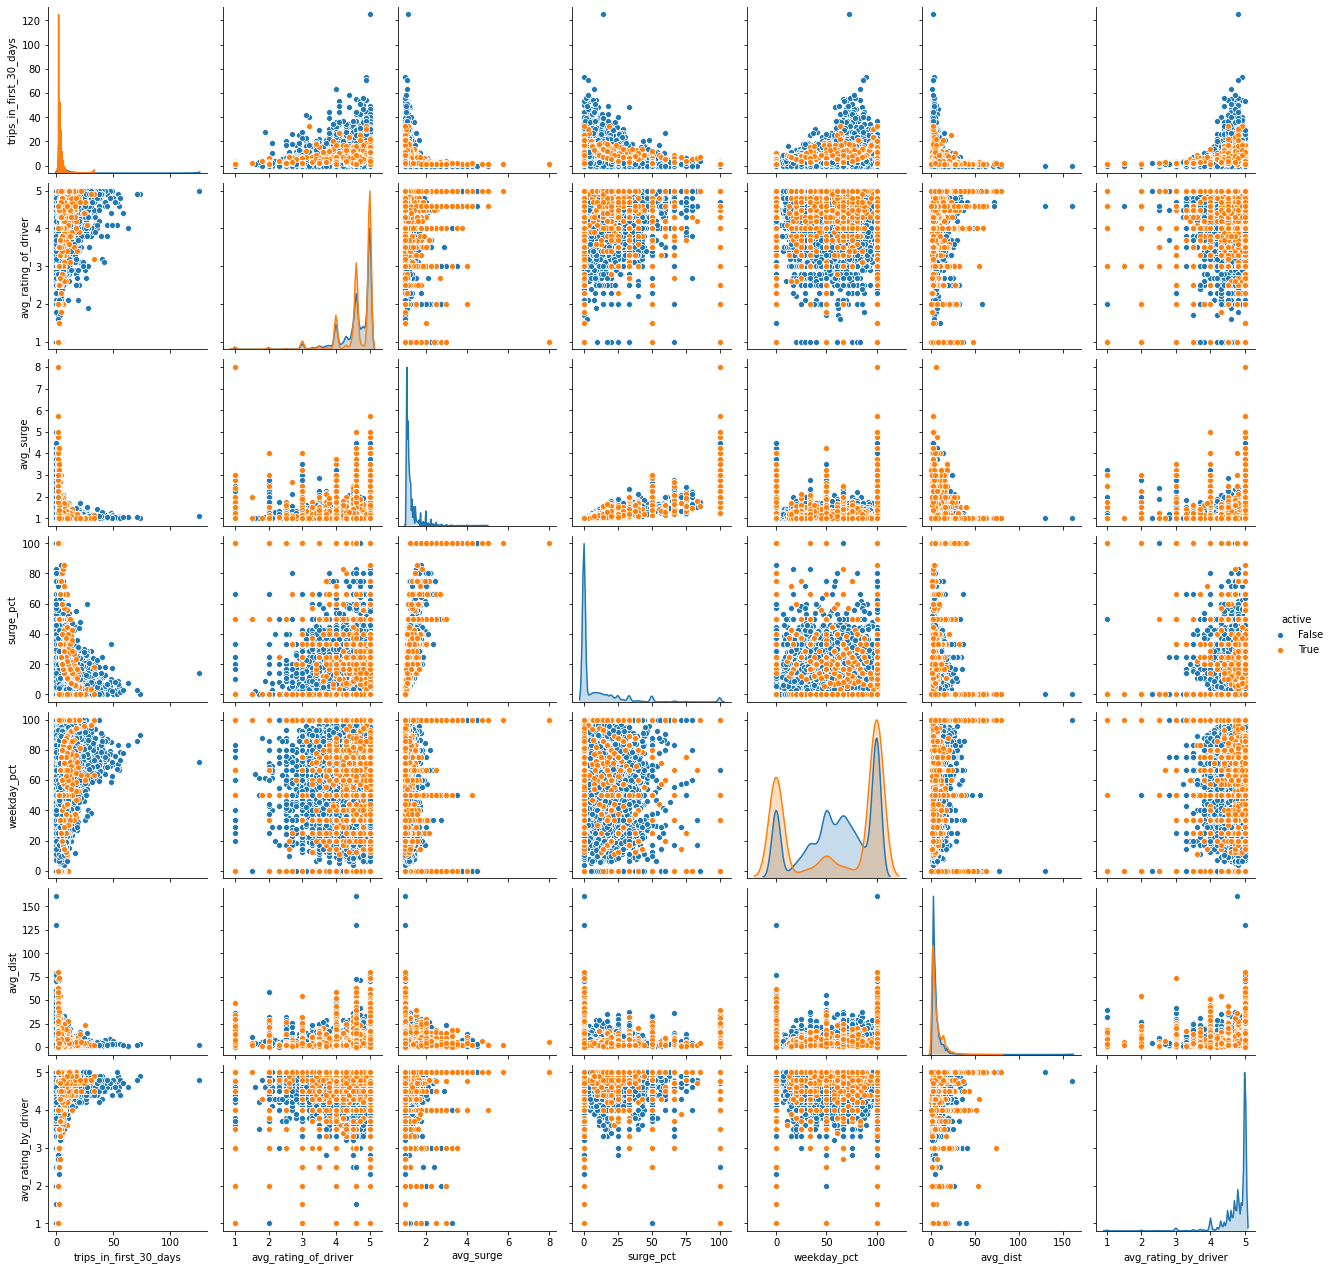

In [10]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

ultimate_num = ultimate.select_dtypes(include=numerics)
ultimate_num.corr().round(2).style.background_gradient(cmap='coolwarm') 
ultimate_num['active'] = ultimate.active.astype('str')
sns.pairplot(ultimate_num, hue='active')

In [11]:
# #sns.h(x ='active', y = 'trips_in_first_30_days', data = ultimate )
# #ultimate.trips_in_first_30_days.hist()
# sns.distplot(ultimate)

ok, there appears to have no correlation between these value beside avg_sur and surge_pct.  However, it seems like the general satisfaction is lower for the active user.

In [12]:
ultimate  = ultimate.drop(columns=['signup_date', 'last_trip_date', 'date_delta'])
ultimate = pd.get_dummies(ultimate, columns=['city','phone','ultimate_black_user','active'], drop_first=True)
ultimate

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True,active_True
0,4,4.700000,1.10,15.4,46.2,3.67,5.0,1,0,1,1,0
1,0,5.000000,1.00,0.0,50.0,8.26,5.0,0,0,0,0,0
2,3,4.300000,1.00,0.0,100.0,0.77,5.0,0,0,1,0,1
3,9,4.600000,1.14,20.0,80.0,2.36,4.9,1,0,1,1,0
4,14,4.400000,1.19,11.8,82.4,3.13,4.9,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.000000,1.00,0.0,100.0,5.63,4.2,1,0,1,0,0
49996,1,4.601559,1.00,0.0,0.0,0.00,4.0,0,0,1,0,1
49997,0,5.000000,1.00,0.0,100.0,3.86,5.0,0,1,0,1,0
49998,2,3.000000,1.00,0.0,100.0,4.58,3.5,0,0,1,0,1


Ok, we have everything in numeric.  Lets perform Train Test Split and set up our scaler

In [13]:
X  = ultimate.drop(columns = 'active_True')
y  = ultimate.active_True

X_train, X_test, y_train, y_test = train_test_split(X,y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Now,lets try to do some model.  Since our result is either 0-1 we will need a classifer.  We will use a basic one logistic and an esemble classifer

The accuracy for the training sets is  0.581
The accuracy for the testing sets is  0.578


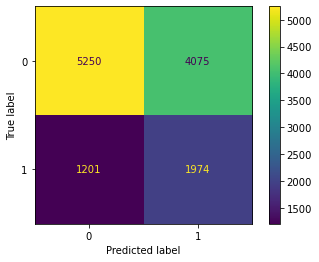

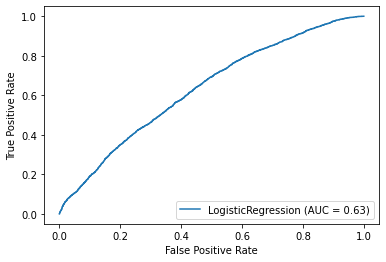

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve

clf = LogisticRegression(class_weight = 'balanced').fit(X_train_scaled, y_train) # balance to handle sample inbalance
print('The accuracy for the training sets is ',clf.score(X_train_scaled, y_train).round(3))
print('The accuracy for the testing sets is ',clf.score(X_test_scaled, y_test).round(3))

plot_confusion_matrix(clf, X_test_scaled, y_test)
plot_roc_curve(clf, X_test_scaled, y_test)

ok, our accuracy is worse than if we just all guess false.  (which is 75 percent)

In [15]:
pd.DataFrame(abs(clf.coef_).T, X.columns, columns=['Coefficient']).sort_values('Coefficient')

,Coefficient
weekday_pct,0.033611
avg_rating_of_driver,0.034709
surge_pct,0.044024
avg_surge,0.061177
city_Winterfell,0.061653
avg_rating_by_driver,0.061806
trips_in_first_30_days,0.113002
avg_dist,0.185288
phone_iPhone,0.242089
ultimate_black_user_True,0.249059


We might need to bring out some of the bigger/sophisciated model

The accuracy for the training sets is  0.998
The accuracy for the testing sets is  0.891


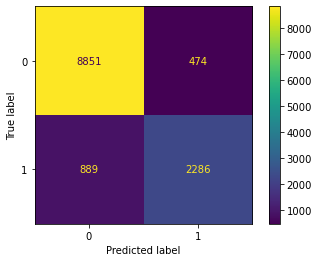

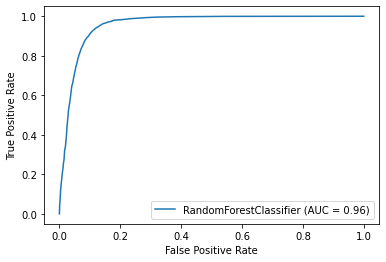

In [16]:
RF = RandomForestClassifier(class_weight = 'balanced').fit(X_train_scaled, y_train) # balance to handle sample inbalance
print('The accuracy for the training sets is ',RF.score(X_train_scaled, y_train).round(3))
print('The accuracy for the testing sets is ',RF.score(X_test_scaled, y_test).round(3))

plot_confusion_matrix(RF, X_test_scaled, y_test)
plot_roc_curve(RF, X_test_scaled, y_test)

In [17]:
pd.DataFrame(abs(RF.feature_importances_).T, X.columns, columns=['Feature Importance']).sort_values('Feature Importance')

,Feature Importance
city_Winterfell,0.006779
phone_iPhone,0.009879
city_King's Landing,0.011252
ultimate_black_user_True,0.011601
avg_surge,0.035682
avg_rating_of_driver,0.041029
surge_pct,0.065932
avg_rating_by_driver,0.121963
avg_dist,0.143306
weekday_pct,0.164862


**2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.**


Ok, I have chosen 2 models for this problem.  Based on the exploratory data analysis, I realized that the relationship between active and non-active user are not very linear.  I chose the logstic regression model just to make sure my prediction is correct.  Indeed, the out of the box for logisitic model only has a 58% accuracy on both training and test set.  This is not good because the data is 75 percent negative.  Therefore, the accuracy is even worse than if we just guess all negative.  

Then we use a more sophisicated model, random forest model, which give us an accuracy of 89 percent with 96 percent on the ROC curve.  Usually I would perform a cross-validation, but since the ROC curve/accuracy is so good already, I will skip this for the time being.  (But I will indicate code on how to do that)

**3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).**

Based on the feature importance, trips in first 30 days appears to the most important indicator whether a person is an active user or not.  Ultimate can leaverage this insight by seeing whether if we can apply some kind of promotion to get the people more active during the first 30 days.